In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./datasets/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


### Read and Split Data

In [2]:
print("Label:\n", df.loc[0, 'Popularity'])
print("Content:\n",df.loc[0,'Page content'])

Label:
 -1
Content:
 <html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks

In [3]:
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape)
print(y_train.shape)
print("Label:\n", y_train[0])
print("Content:\n", X_train[0])

(22114,)
(22114,)
Label:
 -1
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/emily-banks/"><img alt="Default-m" class="author_image" src="http://i.amz.mshcdn.com/raEPzavg65Jzvjy-L4U699QBlmQ=/90x90/default-m.jpg"/></a><span class="author_name">By <a href="/author/emily-banks/">Emily Banks</a></span><time datetime="Fri, 01 Mar 2013 14:53:58 +0000">2013-03-01 14:53:58 UTC</time></span></div></head><body><h1 class="title">Mason Out at Groupon and More News You Need to Know</h1><figure class="article-image"></figure><article data-channel="business"><section class="article-content"> <div class="shift-to-hero"><div class="content-mash-video" data-autoplay="" data-embedurl="http://mashable.com/videos/embed?video=uGc7uydu&amp;player=offsite" data-labels='["Advertising", "Andrew Mason", "CEO", "Facebook", "Groupon", "adidas", "atlas", "college basketball", "first to know", "microsoft", "newsy", "twitter"]' data-playlist="http://content.jwplatform.com/manife

### Feature Engineering

In [4]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub(r'[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [133]:
soup = BeautifulSoup(X_train[0], 'html.parser')
# soup = BeautifulSoup(X_train[0], 'html.parser')
print(soup.prettify())
# beautiful soup tools
print("Title: ", soup.find("h1", {"class": "title"}).text)
print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1))
print("Data Channel: ", soup.find("article").get("data-channel"))
print("Author: ", soup.find("span", {"class": "author_name"}).text.replace("By ", ""))
# print("Author: ", soup.find("span").text)
# print("Author: ", soup.find("a").text)
# print("Data Labels: ", soup.find('div', {'class': 'content-mash-video'}).get('data-labels'))
# print("Data Title: ", soup.find("div", {"class": 'content-mash-video'}).get('data-title'))
print(soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

<html>
 <head>
  <div class="article-info">
   <span class="byline">
    <a href="/author/emily-banks/">
     <img alt="Default-m" class="author_image" src="http://i.amz.mshcdn.com/raEPzavg65Jzvjy-L4U699QBlmQ=/90x90/default-m.jpg"/>
    </a>
    <span class="author_name">
     By
     <a href="/author/emily-banks/">
      Emily Banks
     </a>
    </span>
    <time datetime="Fri, 01 Mar 2013 14:53:58 +0000">
     2013-03-01 14:53:58 UTC
    </time>
   </span>
  </div>
 </head>
 <body>
  <h1 class="title">
   Mason Out at Groupon and More News You Need to Know
  </h1>
  <figure class="article-image">
  </figure>
  <article data-channel="business">
   <section class="article-content">
    <div class="shift-to-hero">
     <div class="content-mash-video" data-autoplay="" data-embedurl="http://mashable.com/videos/embed?video=uGc7uydu&amp;player=offsite" data-labels='["Advertising", "Andrew Mason", "CEO", "Facebook", "Groupon", "adidas", "atlas", "college basketball", "first to know", "micro

In [140]:
def feature_selection(data):
    feature_list = []
    idx = 0
    for html_text in data:
        soup = BeautifulSoup(html_text, 'html.parser')
        feature_map = {}  
        feature_map["Title"] = soup.find("h1", {"class": "title"}).text
        # Author formate may various from news website
        author = soup.find("span", {"class": "author_name"}) # default format
        if(author != None): 
            feature_map["Author"] = author.text.replace("By ", "")
        elif(soup.find("span") != None): 
            feature_map["Author"] = soup.find("span").text
        elif(soup.find("a") != None): 
            feature_map["Author"] = soup.find("a").text
        else: print(idx) # To check the undefine formate
        feature_map["Time"] = re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)
        feature_map["Channel"] = soup.find("article").get("data-channel")
        feature_map["Topics"] = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        # Check if there has any None value feature
        if(feature_map["Title"] == None): print(f"Title: {idx}")
        if(feature_map["Author"] == None): print(f"Author: {idx}")
        if(feature_map["Time"] == None): print(f"Time: {idx}")
        if(feature_map["Channel"] == None): print(f"Channel: {idx}")
        if(feature_map["Topics"] == None): print(f"Topics: {idx}")
        feature_list.append(feature_map)
        idx+=1
    return feature_list 

print(feature_selection(X_valid)[0])

{'Title': 'How Sony lost the Steve Jobs movie: The inside story from the hacked emails', 'Author': 'Christina Warren', 'Time': '23:37:30', 'Channel': 'entertainment', 'Topics': ['Entertainment', ' Movies', ' sony', ' Sony hack', ' Sony Pictures', ' Steve Jobs ']}


In [172]:
def feature_selection(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    
    feature_str += soup.find("h1", {"class": "title"}).text + " "
    # Author formate may various from news website
    author = soup.find("span", {"class": "author_name"}) # default format
    if(author != None): 
        feature_str += author.text.replace("By ", "") + " "
    elif(soup.find("span") != None): 
        feature_str += soup.find("span").text + " "
    elif(soup.find("a") != None): 
        feature_str += soup.find("a").text + " "
    if(re.search(r'(\d+:\d+:\d+)', soup.time.text) == None):
        feature_str += ""
    else: feature_str += re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1) + " "
    feature_str += soup.find("article").get("data-channel") + " "
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")
    
    return feature_str

print(feature_selection(X_valid[0]))

How Sony lost the Steve Jobs movie: The inside story from the hacked emails Christina Warren 23:37:30 entertainment Entertainment Movies sony Sony hack Sony Pictures Steve Jobs 


In [145]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

print(tokenizer_stem_nostop(feature_selection(X_valid[0])))

['how', 'soni', 'lost', 'steve', 'job', 'movie:', 'the', 'insid', 'stori', 'hack', 'email', 'christina', 'warren', 'entertain', 'entertain', 'movi', 'soni', 'soni', 'hack', 'soni', 'pictur', 'steve', 'job']


In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection,
                        tokenizer=tokenizer_stem_nostop)

tfidf.fit(X_train)

top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # When sklearn version <= 0.24.x, should use get_feature_names()
    # When sklearn version >= 1.0.x, should use get_feature_names_out()
    print('%s: %.2f' %(tfidf.get_feature_names_out()[sorted_idx[i]], idf[sorted_idx[i]]))


# doc_tfidf = tfidf.transform(X_train).toarray()
# tfidf_sum = np.sum(doc_tfidf, axis=0)
# print("\n[vocabularies with highest tf-idf scores]")
# for tok, v in zip(tfidf.inverse_transform(np.ones((1, tfidf_sum.shape[0])))[0][tfidf_sum.argsort()[::-1]][:top], \
#                         np.sort(tfidf_sum)[::-1][:top]):
#     print('{}: {}'.format(tok, v))

c:\Users\user\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[vocabularies with smallest idf scores]
world: 2.35
tech: 2.58
entertain: 2.68
watercool: 2.71
busi: 2.79
u.s.: 2.80
video: 2.87
app: 3.00
softwar: 3.07
app softwar: 3.08


### Model Training

In [149]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]  # number of training examples
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [174]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

clf = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)

In [175]:
train_auc, val_auc = [], []
iters = 3
batch_size = 512
classes = np.array([-1, 1])

# train_tfidf = tfidf.transform(X_train).toarray()
# valid_tfidf = tfidf.transform(X_valid).toarray()

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = tfidf.transform(x_batch)
        clf.partial_fit(x_batch, y_batch, classes=classes)
        train_score = roc_auc_score(y_batch, clf.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        valid_score = roc_auc_score(y_batch, clf.predict_proba(tfidf.transform(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/3
[512/22114]
Train score: 0.9996640554613894
Valid score: 0.5236447520184545
[1024/22114]
Train score: 0.9895138374104275
Valid score: 0.5408950617283951
[1536/22114]
Train score: 0.9745343511450382
Valid score: 0.4684615384615385
[2048/22114]
Train score: 0.9640415140415141
Valid score: 0.4513648596693579
[2560/22114]
Train score: 0.9331573244616722
Valid score: 0.46168656141701964
[3072/22114]
Train score: 0.9098149774306359
Valid score: 0.5459104938271605
[3584/22114]
Train score: 0.8937552549109531
Valid score: 0.41451612903225804
[4096/22114]
Train score: 0.8571428571428571
Valid score: 0.5807692307692308
[4608/22114]
Train score: 0.8479083969465648
Valid score: 0.47374608150470215
[5120/22114]
Train score: 0.8385022981660483
Valid score: 0.5609381007304882
[5632/22114]
Train score: 0.8302117201691319
Valid score: 0.5497076023391813
[6144/22114]
Train score: 0.807796111145188
Valid score: 0.5450292397660819
[6656/22114]
Train score: 0.8142169227241458
Valid score: 0.5209

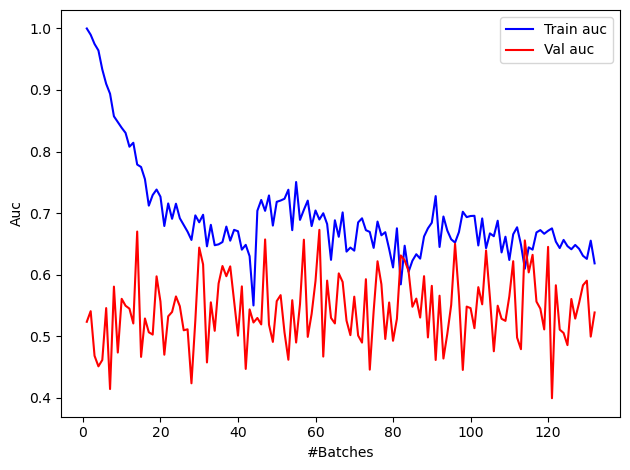

In [176]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [177]:
valid_score = roc_auc_score(y_valid, clf.predict_proba(tfidf.transform(X_valid))[:,1])
print(f'Valid score: {valid_score}')

Valid score: 0.5480339450338462


In [178]:
print(clf.predict_proba(tfidf.transform(X_train[:10]))[:10,1])

[0.4886376  0.49345228 0.49290731 0.49140926 0.49009799 0.49540789
 0.49986385 0.49041985 0.49210287 0.49624183]


In [182]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

# loss='log' gives logistic regression
# sklearn version > 1.0 should use log_loss
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
hashvec = HashingVectorizer(n_features=2**20,
                            preprocessor=feature_selection, tokenizer=tokenizer_stem_nostop)

In [187]:
batch_size = 512
classes = np.array([-1, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = 3

for i in range(iters):
    print(f"epoch: {i+1}/{iters}")
    train_batches = random_mini_batches(X_train, y_train, batch_size)
    valid_batches = random_mini_batches(X_valid, y_valid, int(batch_size * 0.2))
    idx = 0
    for train_batch in train_batches:
        x_batch, y_batch = train_batch
        x_batch = hashvec.transform(x_batch)
        clf.partial_fit(x_batch, y_batch, classes=classes)
        train_score = roc_auc_score(y_batch, clf.predict_proba(x_batch)[:,1])
        train_auc.append(train_score)
        print(f'[{(idx+1)*batch_size}/{X_train.shape[0]}]')
        print(f'Train score: {train_score}')
        
        x_batch, y_batch = valid_batches[idx]
        valid_score = roc_auc_score(y_batch, clf.predict_proba(hashvec.transform(x_batch))[:,1])
        val_auc.append(valid_score)
        print(f'Valid score: {valid_score}')
        idx+=1

epoch: 1/3
[512/22114]
Train score: 0.8415252808558248
Valid score: 0.501929012345679
[1024/22114]
Train score: 0.8141263940520446
Valid score: 0.4669230769230769
[1536/22114]
Train score: 0.824859619140625
Valid score: 0.48588007736943906
[2048/22114]
Train score: 0.8317387655451285
Valid score: 0.5898919753086419
[2560/22114]
Train score: 0.8276477832512315
Valid score: 0.5849129593810445
[3072/22114]
Train score: 0.8498015267175574
Valid score: 0.48286484405082786
[3584/22114]
Train score: 0.8236596576419748
Valid score: 0.6043829296424451
[4096/22114]
Train score: 0.7977598772535481
Valid score: 0.5109742010011552
[4608/22114]
Train score: 0.7850195742598484
Valid score: 0.3992263056092844
[5120/22114]
Train score: 0.7869042710767022
Valid score: 0.5191489361702128
[5632/22114]
Train score: 0.7850321395775941
Valid score: 0.5277777777777777
[6144/22114]
Train score: 0.8085817648944452
Valid score: 0.4974971120523682
[6656/22114]
Train score: 0.7578792796970399
Valid score: 0.692129

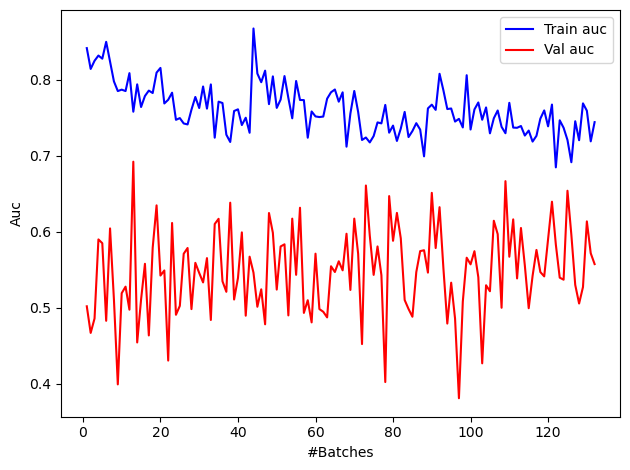

In [188]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

In [189]:
valid_score = roc_auc_score(y_valid, clf.predict_proba(hashvec.transform(X_valid))[:,1])
print(f'Valid score: {valid_score}')

Valid score: 0.5499425647451963


In [190]:
print(clf.predict_proba(hashvec.transform(X_train[:10]))[:10,1])

[0.29760802 0.49435017 0.45325655 0.42135349 0.33515924 0.5454506
 0.60607179 0.36541647 0.560992   0.67747457]


### Prediction

In [191]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [193]:
y_pred = np.around(clf.predict_proba(hashvec.transform(X_test))[:,1], decimals=1)
print(y_pred.shape)
print(y_pred[0])

(11847,)
0.4


In [194]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643         0.4
1      27644         0.7
2      27645         0.4
3      27646         0.4
4      27647         0.5
...      ...         ...
11842  39485         0.5
11843  39486         0.5
11844  39487         0.5
11845  39488         0.6
11846  39489         0.5

[11847 rows x 2 columns]
